In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/My Drive/data/forestfire.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (10000, 9)


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect,dNBR,Burned
0,0.308193,0.122559,0.271816,0.000976,370.41125,89.99211,52.481003,0.270840,1
1,0.356812,0.135231,0.333193,0.062665,350.72733,89.96256,61.969288,0.270528,1
2,0.328753,0.126444,0.307496,0.000423,300.10056,89.98099,217.747300,0.307073,1
3,0.350441,0.132568,0.306111,0.012674,289.57400,89.98431,40.205303,0.293437,1
4,0.351877,0.128189,0.321083,0.039310,319.29330,89.99313,120.985435,0.281773,1


In [4]:
df = df.replace({
    -32767: np.nan,
    -9999: np.nan
})
df = df.dropna()
df["Burned"] = df["Burned"].astype(int)

In [5]:
print(df.shape)
df.head()

(9975, 9)


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect,dNBR,Burned
0,0.308193,0.122559,0.271816,0.000976,370.41125,89.99211,52.481003,0.270840,1
1,0.356812,0.135231,0.333193,0.062665,350.72733,89.96256,61.969288,0.270528,1
2,0.328753,0.126444,0.307496,0.000423,300.10056,89.98099,217.747300,0.307073,1
3,0.350441,0.132568,0.306111,0.012674,289.57400,89.98431,40.205303,0.293437,1
4,0.351877,0.128189,0.321083,0.039310,319.29330,89.99313,120.985435,0.281773,1


In [6]:
y = df["Burned"]
X = df.drop(columns=["Burned", "dNBR"])

print(X.shape, y.shape)

(9975, 7) (9975,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
lr_grid = {"C": [0.1, 1, 10], "penalty": ["l1", "l2"]}
lr = LogisticRegression(max_iter=500, solver="saga")
lr_search = GridSearchCV(lr, lr_grid, cv=cv, scoring="accuracy", n_jobs=-1)
lr_search.fit(X_train_scaled, y_train)

# SVM
svm_grid = {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}
svm = SVC(kernel="rbf", probability=True)
svm_search = GridSearchCV(svm, svm_grid, cv=cv, scoring="accuracy", n_jobs=-1)
svm_search.fit(X_train_scaled, y_train)

# Random Forest
rf_grid = {"n_estimators": [100, 200], "max_depth": [None, 10]}
rf = RandomForestClassifier(random_state=42)
rf_search = GridSearchCV(rf, rf_grid, cv=cv, scoring="accuracy", n_jobs=-1)
rf_search.fit(X_train, y_train)  # RF uses raw features


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [9]:
from sklearn.metrics import accuracy_score

results = {}

results["Logistic Regression"] = accuracy_score(y_test, lr_search.best_estimator_.predict(X_test_scaled))
results["SVM"] = accuracy_score(y_test, svm_search.best_estimator_.predict(X_test_scaled))
results["Random Forest"] = accuracy_score(y_test, rf_search.best_estimator_.predict(X_test))

results


{'Logistic Regression': 0.9959899749373433,
 'SVM': 0.9979949874686717,
 'Random Forest': 0.9954887218045113}

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

lr_preds = lr_search.best_estimator_.predict(X_test_scaled)
print("\n Logistic Regression – Confusion Matrix")
print(confusion_matrix(y_test, lr_preds))
print("\nClassification Report:")
print(classification_report(y_test, lr_preds))


svm_preds = svm_search.best_estimator_.predict(X_test_scaled)
print("\n SVM – Confusion Matrix")
print(confusion_matrix(y_test, svm_preds))
print("\nClassification Report:")
print(classification_report(y_test, svm_preds))


rf_preds = rf_search.best_estimator_.predict(X_test)
print("\n Random Forest – Confusion Matrix")
print(confusion_matrix(y_test, rf_preds))
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))



 Logistic Regression – Confusion Matrix
[[989   8]
 [  0 998]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       997
           1       0.99      1.00      1.00       998

    accuracy                           1.00      1995
   macro avg       1.00      1.00      1.00      1995
weighted avg       1.00      1.00      1.00      1995


 SVM – Confusion Matrix
[[993   4]
 [  0 998]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00       998

    accuracy                           1.00      1995
   macro avg       1.00      1.00      1.00      1995
weighted avg       1.00      1.00      1.00      1995


 Random Forest – Confusion Matrix
[[988   9]
 [  0 998]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      

In [10]:
import pandas as pd

rf_best = rf_search.best_estimator_

fi = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
}).sort_values(by="Importance", ascending=False)

fi


,Feature,Importance
2,nbr_pre,0.348422
0,ndvi_pre,0.321956
3,nbr_post,0.181657
5,slope,0.062423
1,ndvi_post,0.055190
4,elevation,0.026446
6,aspect,0.003906


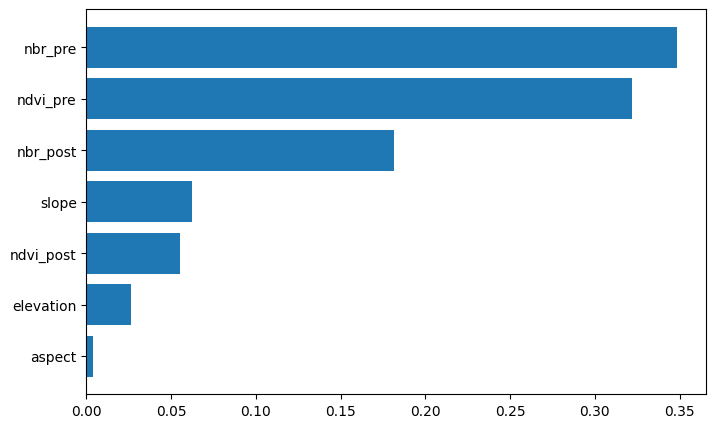

In [11]:
plt.figure(figsize=(8,5))
plt.barh(fi["Feature"], fi["Importance"])
plt.gca().invert_yaxis()
plt.show()

In [12]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling


def align_to_master(src_path, master_meta):
    with rasterio.open(src_path) as src:
        data = src.read(1)

        dst = np.empty((master_meta['height'], master_meta['width']),
                       dtype=np.float32)

        reproject(
            source=data,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=master_meta['transform'],
            dst_crs=master_meta['crs'],
            resampling=Resampling.bilinear
        )
    return dst


FEATURES_PATH = "/content/drive/My Drive/data/features"

feature_names = [
    "ndvi_pre",
    "ndvi_post",
    "nbr_pre",
    "nbr_post",
    "elevation",
    "slope",
    "aspect"
]


master_path = f"{FEATURES_PATH}/ndvi_pre.tif"

with rasterio.open(master_path) as src:
    master_meta = src.meta.copy()
    H, W = src.height, src.width
    print("Master grid:", (H, W))

layers = []

for name in feature_names:
    path = f"{FEATURES_PATH}/{name}.tif"
    aligned = align_to_master(path, master_meta)
    print(f"{name} aligned to {aligned.shape}")
    layers.append(aligned)


stack = np.stack(layers, axis=-1)
print("Final stack shape:", stack.shape)


Master grid: (2337, 3669)
ndvi_pre aligned to (2337, 3669)
ndvi_post aligned to (2337, 3669)
nbr_pre aligned to (2337, 3669)
nbr_post aligned to (2337, 3669)
elevation aligned to (2337, 3669)
slope aligned to (2337, 3669)
aspect aligned to (2337, 3669)
Final stack shape: (2337, 3669, 7)


In [13]:
rf = rf_search.best_estimator_

flat = stack.reshape(-1, stack.shape[-1])
valid_mask = ~np.any(np.isnan(flat), axis=1)
valid_data = flat[valid_mask]

probs = rf.predict_proba(valid_data)[:, 1]

prob_map = np.full(flat.shape[0], np.nan)
prob_map[valid_mask] = probs
prob_map = prob_map.reshape(H, W)

print("Probability map created:", prob_map.shape)



veg_mask = (stack[..., 0] > 0.3)      # NDVI_pre

slope_mask = (stack[..., 5] > 3)      # slope > 3 degrees

# Combine
safe_mask = veg_mask & slope_mask

prob_map_filtered = prob_map.copy()
prob_map_filtered[~safe_mask] = 0

burn_map = (prob_map_filtered > 0.55).astype(np.uint8)

print("Burned pixels:", burn_map.sum())

out_meta = master_meta.copy()
out_meta.update(
    dtype="uint8",
    count=1,
    nodata=0
)

output_path = "/content/drive/My Drive/data/final_burn_mask_correctedd.tif"

with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(burn_map, 1)

print("Saved corrected burn map:", output_path)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Probability map created: (2337, 3669)
Burned pixels: 40141
Saved corrected burn map: /content/drive/My Drive/data/final_burn_mask_correctedd.tif
